In [1]:
import keras
import os
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from keras import optimizers
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint ,EarlyStopping
from keras import regularizers
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler,MinMaxScaler ,QuantileTransformer, PowerTransformer,RobustScaler, Normalizer
import seaborn as sns

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("DHCP.csv") #원본 데이터
#answer = pd.read_csv("PCA_drop980_155.csv")

In [3]:
data

,Timestamp,Svr_detect,Svr_connect,Ss_request,Ss_Established
0,20210101_0000-0010,0.0,0.0,5.0,8.0
1,20210101_0010-0020,0.0,0.0,4.0,14.0
2,20210101_0020-0030,0.0,0.0,1.0,10.0
3,20210101_0030-0040,0.0,0.0,1.0,14.0
4,20210101_0040-0050,0.0,0.0,2.0,9.0
...,...,...,...,...,...
52555,20211231_2310-2320,0.0,2.0,5.0,15.0
52556,20211231_2320-2330,0.0,4.0,4.0,15.0
52557,20211231_2330-2340,0.0,2.0,3.0,14.0
52558,20211231_2340-2350,0.0,3.0,2.0,12.0


In [4]:
data.fillna(method='ffill', inplace=True)

In [5]:
np.sqrt(data['Svr_connect'])

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
52555    1.414214
52556    2.000000
52557    1.414214
52558    1.732051
52559    1.414214
Name: Svr_connect, Length: 52560, dtype: float64

In [6]:
# data['Svr_error'] = np.sqrt(data['Svr_connect']) + np.sqrt(data['Ss_request']) + np.sqrt(data['Svr_detect'])
data['Svr_error'] = data['Svr_connect'] + data['Ss_request'] + data['Svr_detect']
# data2 = data
# data2['Svr_error']= data['Svr_error'].map(lambda i: np.log(i) if i > 0 else 0)
# data2['Ss_Established']= data['Ss_Established'].map(lambda i: np.log(i) if i > 0 else 0)

In [7]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=6)

prediction = dbscan.fit_predict(data[['Svr_error', 'Ss_Established']])

prediction

array([  0,   1,   2, ...,  55,  60, 111], dtype=int64)

In [8]:
pred = pd.DataFrame(columns=['dbscan'], data = prediction)
pred

,dbscan
0,0
1,1
2,2
3,3
4,4
...,...
52555,130
52556,305
52557,55
52558,60


In [9]:
out_idx = pred[pred['dbscan'] == -1].index
out_idx

Int64Index([   19,    61,    82,   166,   187,   328,   898,  1034,  1273,
             1526,
            ...
            51759, 51760, 51761, 51762, 51763, 51764, 51765, 51871, 52251,
            52313],
           dtype='int64', length=850)

In [10]:
pred['dbscan'] = pred['dbscan'].map(lambda x : 1 if x == -1 else 0) 
pred.value_counts()


dbscan
0         51710
1           850
dtype: int64

In [13]:
data = data[['Svr_error', 'Ss_Established']]

In [14]:
data2 = data.reset_index()
SS = StandardScaler()
data_scaled = SS.fit_transform(data[['Svr_error', 'Ss_Established']])
#SS.fit(data[['server_diff', 'client_diff','sum']])
#data_scaled = SS.transform(data[['server_diff', 'client_diff','sum']]) # 넘파이 어레이로 나옴

data_scaled = pd.DataFrame(data_scaled, columns=['Svr_error', 'Ss_Established'])

data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Svr_error       52560 non-null  float64
 1   Ss_Established  52560 non-null  float64
dtypes: float64(2)
memory usage: 821.4 KB


In [15]:
data_scaled

,Svr_error,Ss_Established
0,0.043636,-0.494572
1,-0.040452,-0.135908
2,-0.292716,-0.375017
3,-0.292716,-0.135908
4,-0.208628,-0.434794
...,...,...
52555,0.211812,-0.076131
52556,0.295900,-0.076131
52557,0.043636,-0.135908
52558,0.043636,-0.255463


In [16]:
test = data_scaled[26064:]

In [17]:
scaled_train = pd.DataFrame(columns=['Svr_error', 'Ss_Established'], data = data_scaled)
scaled_train

scaled_train.drop(out_idx, inplace = True)
scaled_train

,Svr_error,Ss_Established
0,0.043636,-0.494572
1,-0.040452,-0.135908
2,-0.292716,-0.375017
3,-0.292716,-0.135908
4,-0.208628,-0.434794
...,...,...
52555,0.211812,-0.076131
52556,0.295900,-0.076131
52557,0.043636,-0.135908
52558,0.043636,-0.255463


In [18]:
from RobustPCA.rpca import RobustPCA

rpca = RobustPCA()

rpca.fit(scaled_train.to_numpy())
L = rpca.get_low_rank()
S = rpca.get_sparse()

Not converged!
Total error: 0.578121, allowed tolerance: 0.000001


In [19]:
L

array([[ 0.04076973, -0.43927207],
       [-0.04042977, -0.13590453],
       [-0.06980984, -0.37500489],
       ...,
       [ 0.0436048 , -0.13590247],
       [ 0.04357717, -0.25545316],
       [ 0.04360772, -0.01635185]])

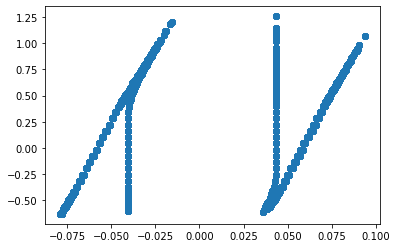

In [20]:
plt.scatter(x = L[:,0], y= L[:,1])

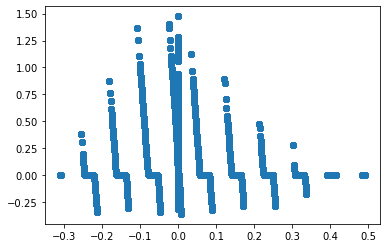

In [21]:
plt.scatter(x = S[:,0], y= S[:,1])

In [22]:
S

array([[ 2.86609745e-03, -5.52995467e-02],
       [-0.00000000e+00, -0.00000000e+00],
       [-2.22906182e-01, -0.00000000e+00],
       ...,
       [ 0.00000000e+00, -0.00000000e+00],
       [ 5.86637267e-05, -0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00]])

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow as tf

In [24]:
nb_epoch = 200
batch_size = 128
input_dim = L.shape[1] #num of predictor variables, 
encoding_dim = 8
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3
drop_rate = 0.2

input_layer = Input(shape=(input_dim, ))
encoder = Dense(8, activation="selu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
# encoder = Dropout(drop_rate)(encoder)
# encoder = BatchNormalization()(encoder)
encoder = Dense(4, activation="selu")(encoder)
# encoder = BatchNormalization()(encoder)
# encoder = Dropout(drop_rate)(encoder)
decoder = Dense(8, activation="selu")(encoder)
# decoder = BatchNormalization()(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 118
Trainable params: 118
Non-trainable params: 0
_________________________________________________________________


In [25]:
df_train, df_valid = train_test_split(L, test_size=0.2, random_state=24)
# df_test = data_scaled[26064:]

In [26]:
np.shape(df_train)

(41368, 2)

In [693]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="PCA_drop3000_log.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

es = EarlyStopping(monitor='val_loss', patience=10,min_delta = 0.001)

history = autoencoder.fit(df_train, df_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1,
                    validation_data=(df_valid, df_valid),
                    callbacks=[cp, tb,es]).history

Epoch 1/200
  1/324 [..............................] - ETA: 1:35 - loss: 0.1303 - accuracy: 0.2109

2022-05-12 23:57:34.029638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


322/324 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9403

2022-05-12 23:57:37.440439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


324/324 [==============================] - 4s 12ms/step - loss: 0.0099 - accuracy: 0.9405 - val_loss: 0.0022 - val_accuracy: 0.9850
Epoch 2/200
324/324 [==============================] - 3s 10ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/200
324/324 [==============================] - 3s 10ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/200
324/324 [==============================] - 3s 10ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/200
324/324 [==============================] - 3s 10ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 9.8938e-04 - val_accuracy: 1.0000
Epoch 6/200
324/324 [==============================] - 3s 10ms/step - loss: 9.3465e-04 - accuracy: 1.0000 - val_loss: 8.8458e-04 - val_accuracy: 1.0000
Epoch 7/200
324/324 [==============================] - 3s 10ms/step - loss: 8.2999e-04 - accuracy: 1.0000 - val_loss: 7.7960e-04 - val_a

In [27]:
import tensorflow as tf
autoencoder = tf.keras.models.load_model("IP_Best_rpca.h5")

In [28]:
M = L + S
test1 = M[26064:]
test = data_scaled[26064:]

In [29]:
test

,Svr_error,Ss_Established
26064,-0.040452,0.043424
26065,-0.208628,0.342310
26066,-0.040452,0.402087
26067,-0.040452,0.043424
26068,0.043636,0.162978
...,...,...
52555,0.211812,-0.076131
52556,0.295900,-0.076131
52557,0.043636,-0.135908
52558,0.043636,-0.255463


In [30]:
test

,Svr_error,Ss_Established
26064,-0.040452,0.043424
26065,-0.208628,0.342310
26066,-0.040452,0.402087
26067,-0.040452,0.043424
26068,0.043636,0.162978
...,...,...
52555,0.211812,-0.076131
52556,0.295900,-0.076131
52557,0.043636,-0.135908
52558,0.043636,-0.255463


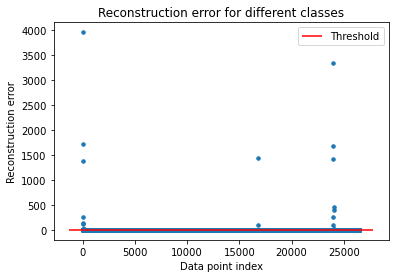

In [31]:
test_x_predictions = autoencoder.predict(test)
mse = np.mean(np.power(test - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse})
error_df_test = error_df_test.reset_index()
df2 = pd.DataFrame(mse)
threshold_fixed = df2[0].quantile(.75) + ((df2[0].quantile(.75) - df2[0].quantile(.25))*100)
threshold_fixed = 0.25
fig, ax = plt.subplots()
ax.plot(error_df_test.index, mse, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [32]:
df2[0].quantile(.75) + ((df2[0].quantile(.75) - df2[0].quantile(.25))*100)

0.07401538069300326

In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

In [34]:
pred_y = [1 if e > threshold_fixed else 0 for e in mse] #예측

In [37]:
unique, counts = np.unique(pred_y, return_counts=True)
dict(zip(unique, counts))

{0: 26345, 1: 151}

In [40]:
answer = pd.DataFrame(columns=['Prediction'],data=pred_y)
answer

,Prediction
0,0
1,0
2,0
3,0
4,0
...,...
26491,0
26492,0
26493,0
26494,0


In [41]:
answer

,Prediction
0,0
1,0
2,0
3,0
4,0
...,...
26491,0
26492,0
26493,0
26494,0


In [42]:
a = answer[answer['Prediction'] == 1].index.tolist()

In [45]:
b = pd.read_csv("이건뭐지.csv")
b

,Unnamed: 0,Prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
26491,26491,0
26492,26492,0
26493,26493,0
26494,26494,0


In [46]:
b_idx = b[b['Prediction'] == 1].index
b_idx

Int64Index([   19,    20,    21,    22,    23,    26,    27,    28,    29,
               30,
            ...
            23921, 24059, 24060, 24061, 24062, 25697, 25698, 25699, 25700,
            25701],
           dtype='int64', length=150)

In [48]:
a = set(a)
b_idx = set(b_idx)
print(len(a.intersection(b_idx)))

150


In [71]:
error_data = [19,
 20,
 21,
 22,
 23,
 26,
 27,
 28,
 29,
 30,
 31,
 161,
 162,
 163,
 167,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 608,
 609,
 610,
 611,
 1503,
 1504,
 1505,
 1506,
 1507,
 1508,
 1509,
 1510,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 3521,
 3522,
 3523,
 3524,
 3525,
 4245,
 4383,
 4386,
 4387,
 4388,
 4389,
 4528,
 4529,
 4530,
 4531,
 4532,
 4533,
 4534,
 4959,
 4960,
 4961,
 4962,
 4963,
 4964,
 4965,
 5070,
 5102,
 5103,
 5104,
 5105,
 5106,
 5107,
 5108,
 5109,
 5198,
 5245,
 5246,
 5247,
 5248,
 5249,
 5250,
 5251,
 5252,
 5253,
 5390,
 5392,
 5393,
 5394,
 5395,
 5396,
 5397,
 5536,
 5537,
 5538,
 5539,
 5540,
 5541,
 5542,
 6543,
 6544,
 6545,
 6546,
 6547,
 6548,
 6549,
 7554,
 7555,
 7556,
 7557,
 8561,
 8562,
 8563,
 8564,
 10021,
 16021,
 16022,
 16165,
 16740,
 16780,
 16781,
 16886,
 16887,
 16933,
 17028,
 17029,
 17634,
 18039,
 18761,
 18762,
 18951,
 19265,
 19910,
 20269,
 20270,
 20276,
 20816,
 20920,
 21822,
 21995,
 21996,
 23917,
 23918,
 23919,
 23920,
 23921,
 24059,
 24060,
 24061,
 24062,
 25697,
 25698,
 25699,
 25700,
 25701]